## Binary classification for sample of galaxies and stars (not QSOs)

In [52]:
data = np.load('sdss_galaxy_colors.npy') #= fetch_sdss_galaxy_colors()

In [53]:
data = pd.DataFrame(data)
data.head()

,u,g,r,i,z,class,z_1,zerr
0,19.38905,18.24496,17.58728,17.20807,16.90905,GALAXY,0.032125,0.000006
1,19.52808,17.96541,17.03493,16.53754,16.14154,GALAXY,0.121315,0.000024
2,18.72268,17.38520,16.81134,16.51803,16.29502,GALAXY,0.048765,0.000014
3,17.65612,16.17133,15.58940,15.37850,15.26744,STAR,-0.000098,0.000008
4,17.54884,15.75164,15.03100,14.66728,14.36099,GALAXY,0.040287,0.000012


In [54]:
data = data.rename(columns={'class':'specClass','z_1':'redshift','zerr':'redshift_err'})

### check classes

In [55]:
data.specClass.value_counts()

STAR      4996
GALAXY    4301
QSO        703
Name: specClass, dtype: int64

### select galaxies and stars

In [56]:
data = data[data.specClass.isin(['GALAXY','STAR'])]

In [57]:
data.specClass.value_counts()

STAR      4996
GALAXY    4301
Name: specClass, dtype: int64

## Check and mask outliers for each column

In [58]:
data.sort_values(by='redshift').head()

,u,g,r,i,z,specClass,redshift,redshift_err
355,18.16801,17.83611,17.15799,16.79025,16.51300,STAR,-0.003479,0.000076
9829,19.33370,18.38404,17.99811,17.84294,17.81207,STAR,-0.003328,0.000158
8150,16.83619,15.74772,15.37244,15.23663,15.21051,STAR,-0.002965,0.000096
1278,18.59334,17.65768,17.28332,17.12765,17.06944,STAR,-0.001192,0.000018
7406,19.06940,18.11597,17.86774,17.78026,17.74762,STAR,-0.001042,0.000029


In [59]:
data.sort_values(by='redshift_err').head()

,u,g,r,i,z,specClass,redshift,redshift_err
1963,15.11673,13.58337,12.98458,12.70121,12.51614,STAR,0.004153,-1.0
6737,17.69350,16.64512,16.32172,16.17824,16.07378,STAR,0.004153,-1.0
6404,18.36191,17.01026,16.28012,15.86637,15.55808,GALAXY,0.000000,0.0
5078,18.10744,16.87588,16.37301,16.15447,16.41539,GALAXY,0.000000,0.0
292,17.14729,15.61818,15.41421,15.62225,15.27046,GALAXY,0.000000,0.0


In [60]:
data.sort_values(by='redshift_err').tail()

,u,g,r,i,z,specClass,redshift,redshift_err
5040,18.56063,19.01776,19.57571,20.01021,20.09951,STAR,0.001028,0.926200
6277,19.55005,19.45104,19.55948,19.68855,19.80340,GALAXY,0.584357,1.361758
2774,19.01388,18.94026,19.13455,19.24360,19.46004,STAR,0.000108,4.022417
6551,18.95801,18.51384,17.70532,16.91748,17.69627,GALAXY,0.663604,12.534570
8783,17.74257,16.48494,15.95276,15.72892,15.61876,GALAXY,0.804514,176.504400


In [61]:
mask = (data.redshift > 0) & (data.redshift_err> 0) & (data.redshift_err < 3)

In [91]:
data[mask].specClass.value_counts()

GALAXY    4274
STAR      3156
Name: specClass, dtype: int64

(10, 22)

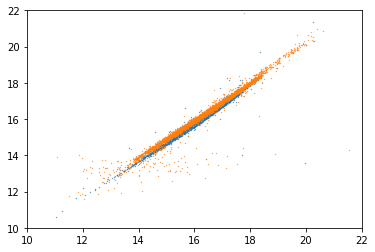

In [64]:
data['ug'] = data.u - data.g
data['gr'] = data.g - data.r
plt.scatter(data[data.specClass=='GALAXY'].i,data[data.specClass=='GALAXY'].z,s=0.1)
plt.scatter(data[data.specClass=='STAR'].i,data[data.specClass=='STAR'].z,s=0.1)
plt.xlim([10,22])
plt.ylim([10,22])

In [65]:
data['target'] = data['specClass'].replace({'GALAXY':0,'STAR':1})

In [66]:
data.head()

,u,g,r,i,z,specClass,redshift,redshift_err,ug,gr,target
0,19.38905,18.24496,17.58728,17.20807,16.90905,GALAXY,0.032125,0.000006,1.14409,0.65768,0
1,19.52808,17.96541,17.03493,16.53754,16.14154,GALAXY,0.121315,0.000024,1.56267,0.93048,0
2,18.72268,17.38520,16.81134,16.51803,16.29502,GALAXY,0.048765,0.000014,1.33748,0.57386,0
3,17.65612,16.17133,15.58940,15.37850,15.26744,STAR,-0.000098,0.000008,1.48479,0.58193,1
4,17.54884,15.75164,15.03100,14.66728,14.36099,GALAXY,0.040287,0.000012,1.79720,0.72064,0


In [67]:
from sklearn import preprocessing, svm, metrics, model_selection

In [68]:
labels = data[mask]['target'] # 目的変数を取り出す
features = preprocessing.minmax_scale(data[mask][['u','g','r','i','z','redshift','redshift_err']]) # 説明変数を取り出した上でスケーリング
x_train, x_test, y_train, y_test = model_selection.train_test_split(features, labels.ravel(), test_size=0.2) # 8対２で分割

In [69]:
features

array([[9.65052416e-01, 7.85267590e-01, 4.55097070e-01, ...,
        5.15352582e-01, 3.95404756e-02, 2.44305280e-06],
       [9.88121273e-01, 7.46726300e-01, 4.13380210e-01, ...,
        4.52496796e-01, 1.49321252e-01, 1.53109744e-05],
       [8.54483518e-01, 6.66733303e-01, 3.96493322e-01, ...,
        4.65066151e-01, 6.00220625e-02, 8.11151631e-06],
       ...,
       [8.08529985e-01, 6.23886363e-01, 3.77782477e-01, ...,
        4.69332918e-01, 9.12356332e-05, 3.88970849e-06],
       [4.70138085e-01, 2.71493094e-01, 1.55020411e-01, ...,
        1.88491194e-01, 2.62626608e-02, 3.15597900e-06],
       [9.45924331e-01, 6.86729829e-01, 3.85442338e-01, ...,
        4.36002997e-01, 9.45666029e-02, 6.84659004e-06]])

## Fisher's linear discriminant
射影ベクトルが物理的意味を持つ可能性があると考えフィッシャー線形判別を試す。

In [70]:
x_train0, x_train1 = x_train[y_train == 0], x_train[y_train == 1]
sw = np.cov(x_train0.T) + np.cov(x_train1.T)
swinv = np.linalg.inv(sw)
m01 = np.mean(x_train0,axis=0) - np.mean(x_train1,axis=0)
proj_vec = np.inner(swinv,m01)
proj_vec

array([ -3.96608074,  10.27472008,  23.70537529,  -4.23303574,
       -27.17871011,  32.04013248, -25.74955569])

uとiの重みが比較的小さいが、全ての特徴量が同じくらいの重みを持つ。
射影空間でのヒストグラムをみる。

In [71]:
proj_xt0, proj_xt1 = np.inner(x_train0,proj_vec), np.inner(x_train1,proj_vec)

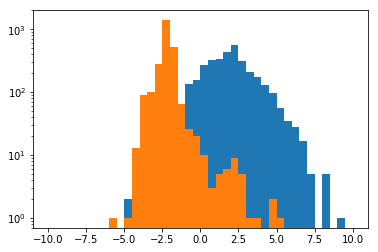

In [77]:
plt.hist(proj_xt0,bins=40,range=[-10,10])
plt.hist(proj_xt1,bins=40,range=[-10,10])
plt.yscale('log')

正答率が最大になる値を境界とする。

In [73]:
proj_xt_conc, type_conc = np.concatenate([proj_xt0,proj_xt1]), np.concatenate([np.full(len(proj_xt0),0),np.full(len(proj_xt1),1)])
#projxt0_df = pd.DataFrame([proj_xt0,np.full(len(proj_xt0),0)],columns=['feature','type'])
#projxt1_df = pd.DataFrame([proj_xt1,np.full(len(proj_xt1),1)],columns=['feature','type'])
#pd.concat([projxt0_df,projxt1_df],ignore_index=True)
proj_type = pd.DataFrame({'feature': proj_xt_conc,'type':type_conc})
proj_type_sort = proj_type.sort_values(by='feature')
#proj_type_sort.feature.rank()
proj_type_sort['accuracy'] = (len(proj_type_sort) + 2*proj_type_sort.type.cumsum() - proj_type_sort.feature.rank() - proj_type_sort.type.sum())/len(proj_type_sort)
proj_type_sort[proj_type_sort.accuracy == proj_type_sort.accuracy.max()]

,feature,type,accuracy
4718,-1.239981,1,0.969213


境界を-1.24とする。その時正答率は97%

テスト集合でもヒストグラムを作ってみる。

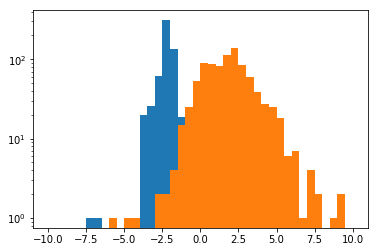

In [78]:
x_test0, x_test1 = x_test[y_test == 0], x_test[y_test == 1]
proj_xs0, proj_xs1 = np.inner(x_test0,proj_vec), np.inner(x_test1,proj_vec)
plt.hist(proj_xs1,bins=40,range=[-10,10])
plt.hist(proj_xs0,bins=40,range=[-10,10])
plt.yscale('log')

テスト集合で正答率を計算。

In [80]:
proj_xs_conc, types_conc = np.concatenate([proj_xs0,proj_xs1]), np.concatenate([np.full(len(proj_xs0),0),np.full(len(proj_xs1),1)])
proj_type_test = pd.DataFrame({'feature': proj_xs_conc,'type':types_conc})
proj_type_sort_test = proj_type_test.sort_values(by='feature')
clfd_1 = proj_type_sort_test[proj_type_sort_test.feature < -1.24]
accuracy = (len(proj_type_sort_test) + 2*clfd_1.type.sum() - len(clfd_1) - proj_type_sort_test.type.sum())/len(proj_type_sort_test)
accuracy

0.9751009421265141

フィッシャー線形判別では97.5%の正答率で判別できることがわかった。

## Linear discriminant analysis with sklearn

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [82]:
accuracy = clf.score(x_test, y_test)
accuracy

0.9522207267833109

フィッシャーより悪い。。

## Classification with SVM

In [83]:
clf = svm.SVC(C=10) #(kernel='rbf', C=10, gamma=0.1)
clf.fit(x_train,y_train) #clf.fit(x_train, y_train)
#scores=cross_validation.cross_val_score(clf, features, labels, cv=5)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
accuracy = clf.score(x_test,y_test)
accuracy

0.9858681022880216

流石にSVMは精度が良い。closs-validationをしないとはっきりとは言えないと思うが。

## Classification with XGBoost

In [88]:
import xgboost as xgb
clf = xgb.XGBRegressor()
clf.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [89]:
accuracy = clf.score(x_test, y_test)

In [90]:
accuracy

0.9999990700873604

？？？